Dataset shape: (569, 30)
Labels shape: (569,)
Classes: ['malignant' 'benign']
Train size: 455
Validation size: 114
Epoch 001/80 | Train Loss: 0.6784 | Val Loss: 0.6562
Epoch 002/80 | Train Loss: 0.6316 | Val Loss: 0.5928
Epoch 003/80 | Train Loss: 0.5436 | Val Loss: 0.4798
Epoch 004/80 | Train Loss: 0.4065 | Val Loss: 0.3372
Epoch 005/80 | Train Loss: 0.2533 | Val Loss: 0.2141
Epoch 006/80 | Train Loss: 0.1476 | Val Loss: 0.1446
Epoch 007/80 | Train Loss: 0.1006 | Val Loss: 0.1148
Epoch 008/80 | Train Loss: 0.0803 | Val Loss: 0.1024
Epoch 009/80 | Train Loss: 0.0703 | Val Loss: 0.0940
Epoch 010/80 | Train Loss: 0.0624 | Val Loss: 0.0971
Epoch 011/80 | Train Loss: 0.0566 | Val Loss: 0.0916
Epoch 012/80 | Train Loss: 0.0529 | Val Loss: 0.0854
Epoch 013/80 | Train Loss: 0.0481 | Val Loss: 0.0885
Epoch 014/80 | Train Loss: 0.0452 | Val Loss: 0.0877
Epoch 015/80 | Train Loss: 0.0418 | Val Loss: 0.0898
Epoch 016/80 | Train Loss: 0.0394 | Val Loss: 0.0871
Epoch 017/80 | Train Loss: 0.0373 | V

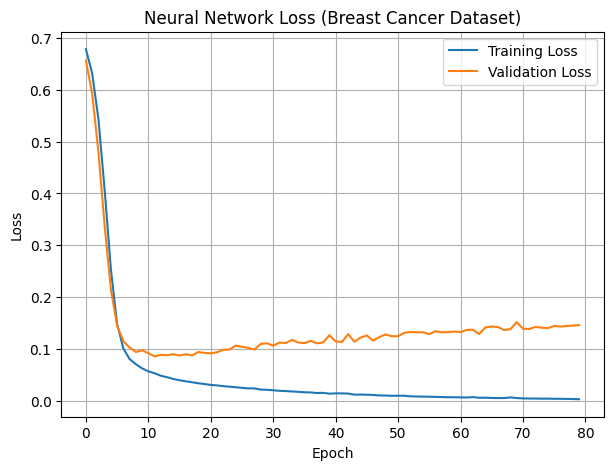


Neural Network Metrics:
Accuracy : 0.9649
Precision: 0.9857
Recall   : 0.9583
F1-score : 0.9718

Logistic Regression Metrics:
Accuracy : 0.9825
Precision: 0.9861
Recall   : 0.9861
F1-score : 0.9861

SVM (RBF) Metrics:
Accuracy : 0.9825
Precision: 0.9861
Recall   : 0.9861
F1-score : 0.9861

Summary of Model Performance:

                     Accuracy  Precision    Recall        F1
Neural Network       0.964912   0.985714  0.958333  0.971831
Logistic Regression  0.982456   0.986111  0.986111  0.986111
SVM (RBF)            0.982456   0.986111  0.986111  0.986111


In [1]:
# =====================================
# Problem 2 – Breast Cancer Dataset
# Mohammadmilad_Sayyad
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# --------------------------
# 1. Load Breast Cancer Dataset
# --------------------------
data = load_breast_cancer()
X = data.data.astype(np.float32)
y = data.target.astype(np.float32)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", data.target_names)

# --------------------------
# 2. Train / Validation Split (80/20)
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])

# --------------------------
# 3. Standardize Features
# --------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# --------------------------
# 4. Fully Connected Neural Network
# --------------------------
input_dim = X_train_scaled.shape[1]  # 30 features

class CancerNet(nn.Module):
    def __init__(self, input_dim):
        super(CancerNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model = CancerNet(input_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# --------------------------
# 5. Dataloaders
# --------------------------
batch_size = 32

train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).view(-1,1)
    ),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_val_scaled, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).view(-1,1)
    ),
    batch_size=batch_size,
    shuffle=False
)

# --------------------------
# 6. Training Loop
# --------------------------
num_epochs = 80
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            running_val_loss += loss.item() * xb.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1:03d}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# --------------------------
# 7. Loss Plot
# --------------------------
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Neural Network Loss (Breast Cancer Dataset)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 8. Compute Metrics
# --------------------------
def compute_and_print_metrics(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{name} Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    return acc, prec, rec, f1

# NN predictions
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_val_scaled, dtype=torch.float32))
    probs = torch.sigmoid(logits).numpy().ravel()
    y_pred_nn = (probs >= 0.5).astype(int)

nn_results = compute_and_print_metrics(y_val, y_pred_nn, "Neural Network")


# --------------------------
# 9. Logistic Regression
# --------------------------
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

lr_results = compute_and_print_metrics(y_val, y_pred_lr, "Logistic Regression")


# --------------------------
# 10. SVM (RBF Kernel)
# --------------------------
svm_clf = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_val_scaled)

svm_results = compute_and_print_metrics(y_val, y_pred_svm, "SVM (RBF)")


# --------------------------
# 11. Summary Table
# --------------------------
results_df = pd.DataFrame(
    [nn_results, lr_results, svm_results],
    index=["Neural Network", "Logistic Regression", "SVM (RBF)"],
    columns=["Accuracy", "Precision", "Recall", "F1"]
)

print("\nSummary of Model Performance:\n")
print(results_df)
